# FX Volatility Project: Data Preparation

This notebook focuses on collecting, cleaning, and preparing data for the FX Volatility Regime Analysis project. We'll gather historical FX data, macroeconomic indicators, and create derived features for our analysis.

In [21]:
from plot_utils import set_dark_theme
set_dark_theme()

In [22]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime, timedelta
import os
import sys

# Add project directory to path
sys.path.append('..')

# Import project modules
from src.data_utils import (
    fetch_fx_data, 
    fetch_economic_data, 
    calculate_returns, 
    create_lagged_features,
    calculate_rolling_volatility
)

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_palette("deep")
plt.rcParams["figure.figsize"] = (14, 8)

# Create directories if they don't exist
os.makedirs('../data/raw', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

## 1. Data Collection

We'll collect data for major currency pairs and relevant economic indicators.

In [23]:
# Define time period
start_date = '2010-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

# Define currency pairs to analyze
fx_pairs = ['EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'AUDUSD=X', 'USDCAD=X', 'USDCHF=X']

# Fetch FX data
print(f"Fetching FX data from {start_date} to {end_date}...")
fx_data = fetch_fx_data(fx_pairs, start_date, end_date)

# Display the first few rows
print("\nFX Data Preview:")
fx_data.head()

Fetching FX data from 2010-01-01 to 2025-06-02...

FX Data Preview:


,EURUSD,GBPUSD,USDJPY,AUDUSD,USDCAD,USDCHF
Date,,,,,,
2010-01-01 00:00:00+00:00,1.438994,1.613294,92.919998,0.898473,1.0512,1.0339
2010-01-04 00:00:00+00:00,1.442398,1.611370,92.495003,0.912492,1.0410,1.0291
2010-01-05 00:00:00+00:00,1.436596,1.599079,91.584999,0.911826,1.0395,1.0337
2010-01-06 00:00:00+00:00,1.440403,1.602384,92.356003,0.920471,1.0319,1.0276
2010-01-07 00:00:00+00:00,1.431803,1.593397,93.389999,0.917768,1.0340,1.0336


In [24]:
# Define economic indicators to fetch from FRED
economic_indicators = [
    'DGS10',    # 10-Year Treasury Constant Maturity Rate
    'DGS2',     # 2-Year Treasury Constant Maturity Rate
    'T10Y2Y',   # 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity
    'DTWEXBGS', # Trade Weighted U.S. Dollar Index: Broad
    'VIXCLS',   # CBOE Volatility Index: VIX
    'DCOILWTICO' # Crude Oil Prices: West Texas Intermediate (WTI)
]

# Fetch economic data
print(f"Fetching economic indicators from {start_date} to {end_date}...")
economic_data = fetch_economic_data(economic_indicators, start_date, end_date)

# Display the first few rows
print("\nEconomic Data Preview:")
economic_data.head()

Fetching economic indicators from 2010-01-01 to 2025-06-02...

Economic Data Preview:


,DGS10,DGS2,T10Y2Y,DTWEXBGS,VIXCLS,DCOILWTICO
DATE,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,3.85,1.09,2.76,92.3566,20.04,81.52
2010-01-05,3.77,1.01,2.76,92.2236,19.35,81.74
2010-01-06,3.85,1.01,2.84,92.0941,19.16,83.12
2010-01-07,3.85,1.03,2.82,92.3684,19.06,82.60


In [25]:
# Save raw data
fx_data.to_csv('../data/raw/fx_data.csv')
economic_data.to_csv('../data/raw/economic_data.csv')

print("Raw data saved to disk.")

Raw data saved to disk.


## 2. Data Cleaning and Preprocessing

Now we'll clean the data and handle missing values.

In [26]:
# Check for missing values
print("Missing values in FX data:")
print(fx_data.isnull().sum())

print("\nMissing values in economic data:")
print(economic_data.isnull().sum())

Missing values in FX data:
EURUSD    1
GBPUSD    1
USDJPY    1
AUDUSD    2
USDCAD    2
USDCHF    4
dtype: int64

Missing values in economic data:
DGS10         167
DGS2          167
T10Y2Y        166
DTWEXBGS      189
VIXCLS        123
DCOILWTICO    157
dtype: int64


In [27]:
# Forward fill missing values in economic data (common for economic indicators)
economic_data_filled = economic_data.fillna(method='ffill')

# Check if there are still missing values
print("Remaining missing values in economic data after forward fill:")
print(economic_data_filled.isnull().sum())

# If there are still missing values at the beginning, backward fill
economic_data_filled = economic_data_filled.fillna(method='bfill')

# Verify all missing values are handled
print("\nFinal check for missing values:")
print(economic_data_filled.isnull().sum())

Remaining missing values in economic data after forward fill:
DGS10         1
DGS2          1
T10Y2Y        1
DTWEXBGS      1
VIXCLS        1
DCOILWTICO    1
dtype: int64

Final check for missing values:
DGS10         0
DGS2          0
T10Y2Y        0
DTWEXBGS      0
VIXCLS        0
DCOILWTICO    0
dtype: int64


/var/folders/2_/fspnp6z50cncz225wh82h16c0000gn/T/ipykernel_85316/2141031965.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  economic_data_filled = economic_data.fillna(method='ffill')
/var/folders/2_/fspnp6z50cncz225wh82h16c0000gn/T/ipykernel_85316/2141031965.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  economic_data_filled = economic_data_filled.fillna(method='bfill')


## 3. Feature Engineering

We'll create derived features for our analysis, including returns, volatility measures, and lagged variables.

In [28]:
# Calculate log returns for FX pairs
fx_returns = calculate_returns(fx_data, method='log')

# Calculate percentage changes for economic indicators
economic_changes = economic_data_filled.pct_change()

# Display the first few rows of returns
print("FX Returns Preview:")
fx_returns.head()

FX Returns Preview:


,EURUSD,GBPUSD,USDJPY,AUDUSD,USDCAD,USDCHF
Date,,,,,,
2010-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04 00:00:00+00:00,0.002363,-0.001193,-0.004584,0.015483,-0.009751,-0.004654
2010-01-05 00:00:00+00:00,-0.004031,-0.007657,-0.009887,-0.000730,-0.001442,0.004460
2010-01-06 00:00:00+00:00,0.002647,0.002065,0.008383,0.009436,-0.007338,-0.005919
2010-01-07 00:00:00+00:00,-0.005989,-0.005625,0.011134,-0.002941,0.002033,0.005822


In [29]:
# Calculate rolling volatility for different window sizes
volatility_windows = [5, 10, 22, 66]  # 1 week, 2 weeks, 1 month, 3 months
fx_volatility = calculate_rolling_volatility(fx_returns, windows=volatility_windows)

# Display the first few rows of volatility measures
print("FX Volatility Preview:")
fx_volatility.head()

FX Volatility Preview:


,EURUSD_vol_5d,EURUSD_vol_10d,EURUSD_vol_22d,EURUSD_vol_66d,GBPUSD_vol_5d,GBPUSD_vol_10d,GBPUSD_vol_22d,GBPUSD_vol_66d,USDJPY_vol_5d,USDJPY_vol_10d,...,AUDUSD_vol_22d,AUDUSD_vol_66d,USDCAD_vol_5d,USDCAD_vol_10d,USDCAD_vol_22d,USDCAD_vol_66d,USDCHF_vol_5d,USDCHF_vol_10d,USDCHF_vol_22d,USDCHF_vol_66d
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Create lagged features for FX returns
lags = [1, 2, 3, 5, 10]
fx_returns_lagged = create_lagged_features(fx_returns, fx_returns.columns.tolist(), lags)

# Create lagged features for economic indicators
economic_changes_lagged = create_lagged_features(economic_changes, economic_changes.columns.tolist(), lags)

# Display the first few rows of lagged features
print("Lagged FX Returns Preview:")
fx_returns_lagged.head()

Lagged FX Returns Preview:


,EURUSD,GBPUSD,USDJPY,AUDUSD,USDCAD,USDCHF,EURUSD_lag1,EURUSD_lag2,EURUSD_lag3,EURUSD_lag5,...,USDCAD_lag1,USDCAD_lag2,USDCAD_lag3,USDCAD_lag5,USDCAD_lag10,USDCHF_lag1,USDCHF_lag2,USDCHF_lag3,USDCHF_lag5,USDCHF_lag10
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04 00:00:00+00:00,0.002363,-0.001193,-0.004584,0.015483,-0.009751,-0.004654,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05 00:00:00+00:00,-0.004031,-0.007657,-0.009887,-0.000730,-0.001442,0.004460,0.002363,NaN,NaN,NaN,...,-0.009751,NaN,NaN,NaN,NaN,-0.004654,NaN,NaN,NaN,NaN
2010-01-06 00:00:00+00:00,0.002647,0.002065,0.008383,0.009436,-0.007338,-0.005919,-0.004031,0.002363,NaN,NaN,...,-0.001442,-0.009751,NaN,NaN,NaN,0.004460,-0.004654,NaN,NaN,NaN
2010-01-07 00:00:00+00:00,-0.005989,-0.005625,0.011134,-0.002941,0.002033,0.005822,0.002647,-0.004031,0.002363,NaN,...,-0.007338,-0.001442,-0.009751,NaN,NaN,-0.005919,0.004460,-0.004654,NaN,NaN


In [31]:
# Create interest rate differentials
economic_data_filled['US_EU_RATE_DIFF'] = economic_data_filled['DGS10'] - 0.5  # Approximation for EU rates
economic_data_filled['US_UK_RATE_DIFF'] = economic_data_filled['DGS10'] - 0.7  # Approximation for UK rates
economic_data_filled['US_JP_RATE_DIFF'] = economic_data_filled['DGS10'] - 0.1  # Approximation for JP rates

# Calculate yield curve slope
economic_data_filled['YIELD_CURVE_SLOPE'] = economic_data_filled['DGS10'] - economic_data_filled['DGS2']

# Display the new features
print("Economic Indicators with Derived Features:")
economic_data_filled[['DGS10', 'DGS2', 'US_EU_RATE_DIFF', 'US_UK_RATE_DIFF', 'US_JP_RATE_DIFF', 'YIELD_CURVE_SLOPE']].head()

Economic Indicators with Derived Features:


,DGS10,DGS2,US_EU_RATE_DIFF,US_UK_RATE_DIFF,US_JP_RATE_DIFF,YIELD_CURVE_SLOPE
DATE,,,,,,
2010-01-01,3.85,1.09,3.35,3.15,3.75,2.76
2010-01-04,3.85,1.09,3.35,3.15,3.75,2.76
2010-01-05,3.77,1.01,3.27,3.07,3.67,2.76
2010-01-06,3.85,1.01,3.35,3.15,3.75,2.84
2010-01-07,3.85,1.03,3.35,3.15,3.75,2.82


## 4. Merge Data and Prepare for Modeling

Now we'll merge all the data and prepare it for modeling.

In [32]:
# Before merging, standardize the timezone handling
# Option 1: Convert all to timezone-naive
fx_returns.index = fx_returns.index.tz_localize(None)
fx_volatility.index = fx_volatility.index.tz_localize(None)
economic_data_filled.index = economic_data_filled.index.tz_localize(None)

# OR Option 2: Convert all to the same timezone
# fx_returns.index = fx_returns.index.tz_convert('UTC')
# fx_volatility.index = fx_volatility.index.tz_localize('UTC', ambiguous='raise')
# economic_data_filled.index = economic_data_filled.index.tz_localize('UTC', ambiguous='raise')

# Now merge the data

In [33]:
# Merge FX returns, volatility, and economic data
merged_data = pd.concat([fx_returns, fx_volatility, economic_data_filled], axis=1)

# Add lagged features
for pair in fx_returns.columns:
    for lag in lags:
        merged_data[f"{pair}_lag{lag}"] = fx_returns[pair].shift(lag)

for indicator in economic_changes.columns:
    for lag in lags:
        merged_data[f"{indicator}_change_lag{lag}"] = economic_changes[indicator].shift(lag)

# Drop rows with NaN values
merged_data_clean = merged_data.dropna()

# Display the shape of the final dataset
print(f"Final dataset shape: {merged_data_clean.shape}")
print(f"Number of features: {merged_data_clean.shape[1]}")
print(f"Date range: {merged_data_clean.index.min()} to {merged_data_clean.index.max()}")

Final dataset shape: (3729, 100)
Number of features: 100
Date range: 2010-04-05 00:00:00 to 2025-05-30 00:00:00


In [34]:
# Save processed data
merged_data_clean.to_csv('../data/processed/merged_data.csv')

# Also save individual components for easier access
fx_returns.to_csv('../data/processed/fx_returns.csv')
fx_volatility.to_csv('../data/processed/fx_volatility.csv')
economic_data_filled.to_csv('../data/processed/economic_data_filled.csv')

print("Processed data saved to disk.")

Processed data saved to disk.


## 5. Data Overview

Let's take a quick look at the data we've prepared.

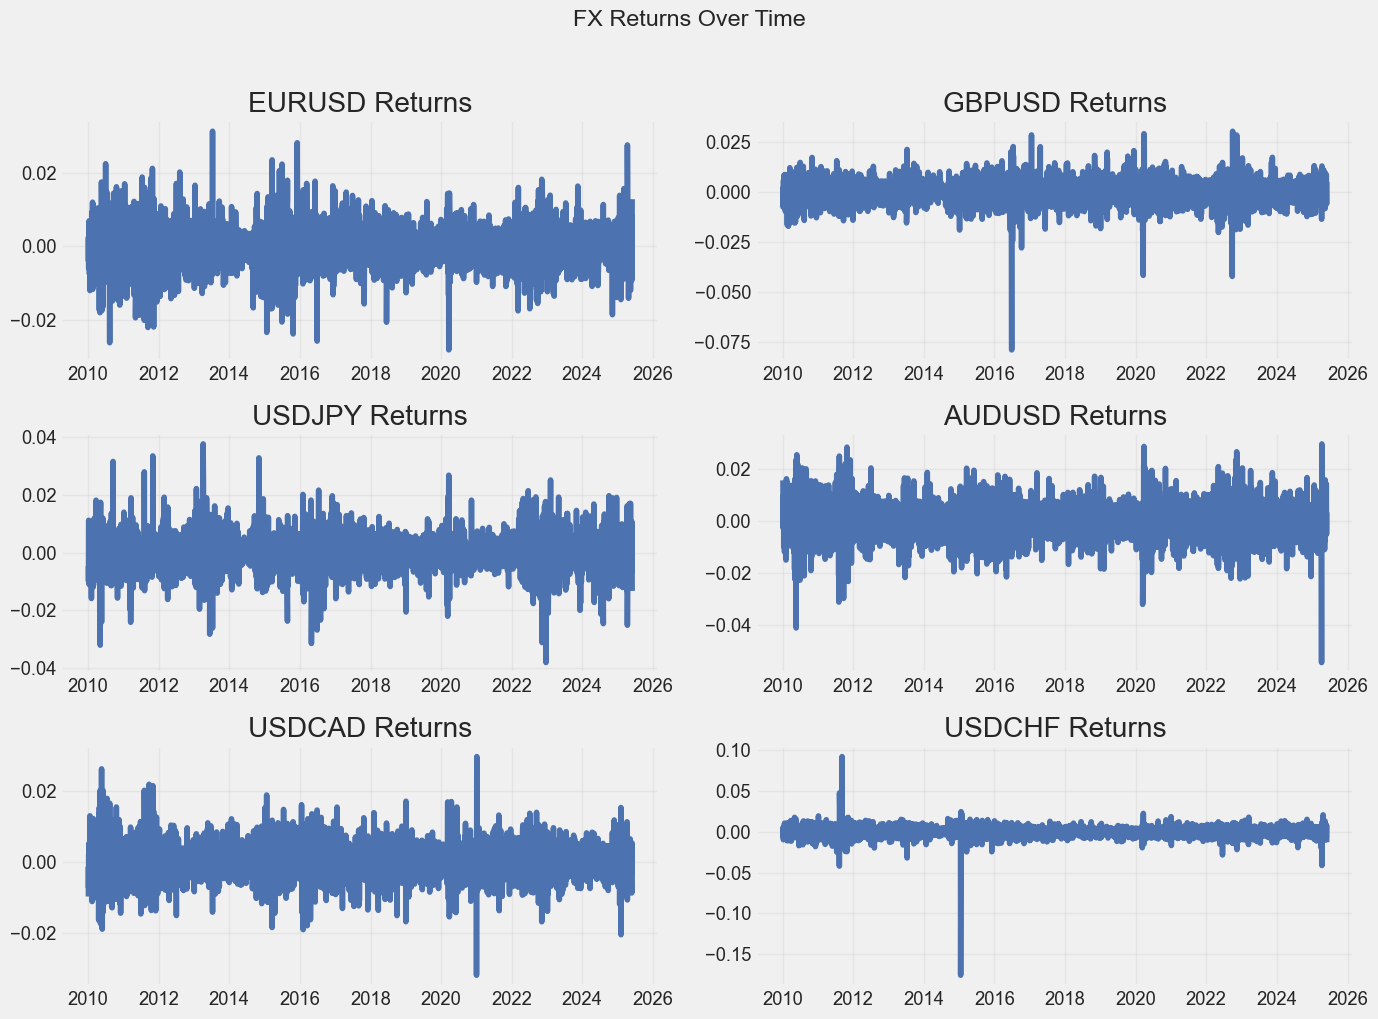

In [35]:
# Plot FX returns
plt.figure(figsize=(14, 10))

for i, pair in enumerate(fx_returns.columns):
    plt.subplot(3, 2, i+1)
    plt.plot(fx_returns.index, fx_returns[pair])
    plt.title(f'{pair} Returns')
    plt.tight_layout()

plt.suptitle('FX Returns Over Time', y=1.02)
plt.tight_layout()
plt.show()

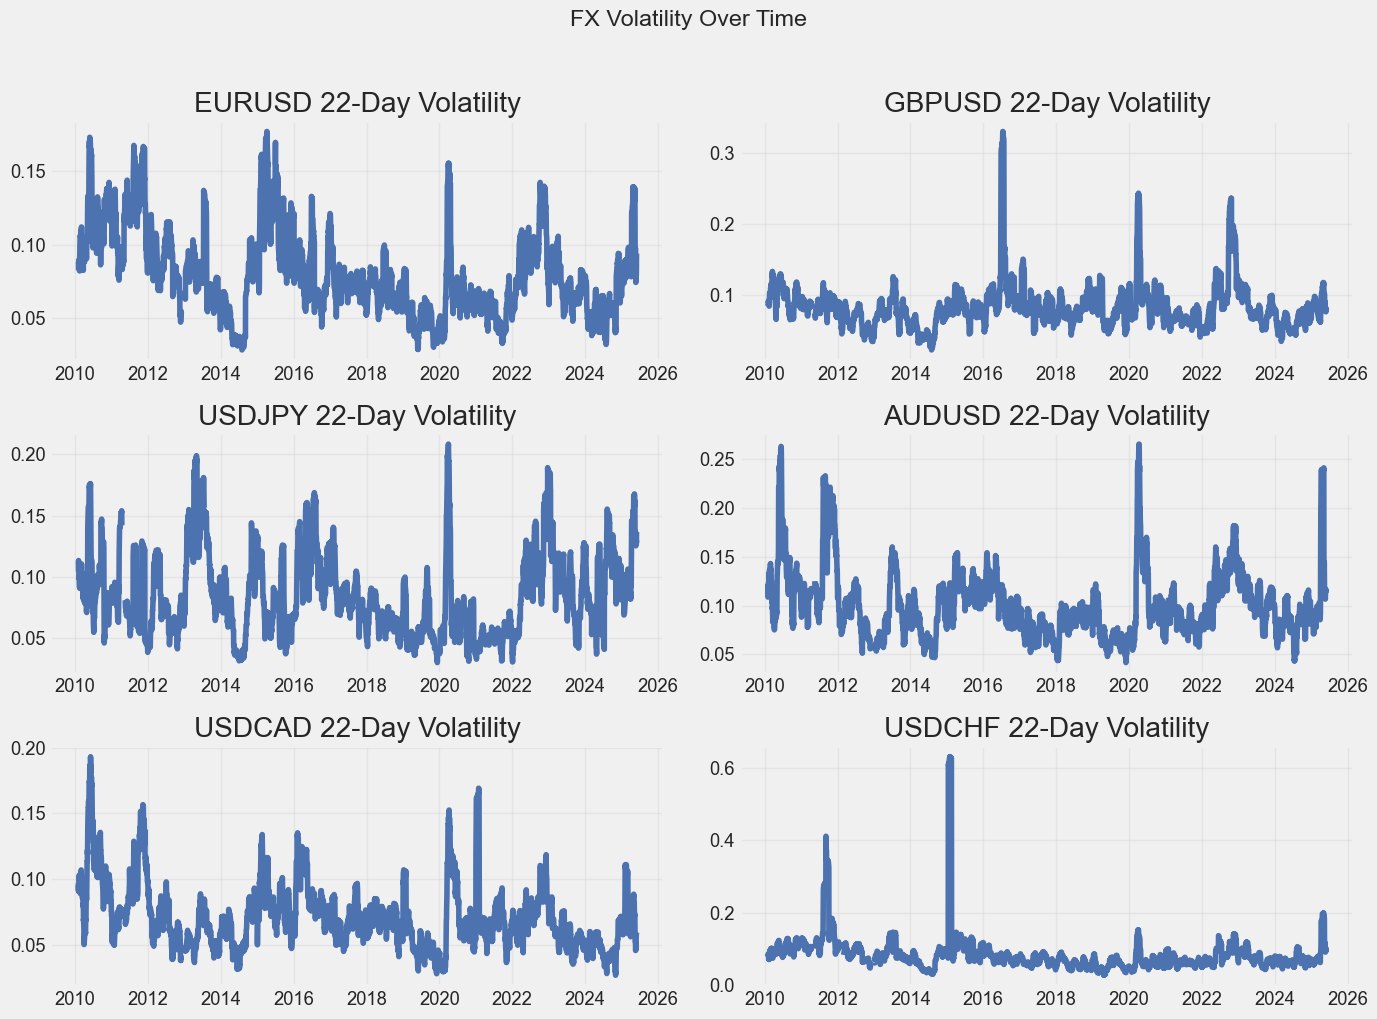

In [36]:
# Plot 22-day rolling volatility
plt.figure(figsize=(14, 10))

for i, pair in enumerate(fx_returns.columns):
    plt.subplot(3, 2, i+1)
    plt.plot(fx_volatility.index, fx_volatility[f'{pair}_vol_22d'])
    plt.title(f'{pair} 22-Day Volatility')
    plt.tight_layout()

plt.suptitle('FX Volatility Over Time', y=1.02)
plt.tight_layout()
plt.show()

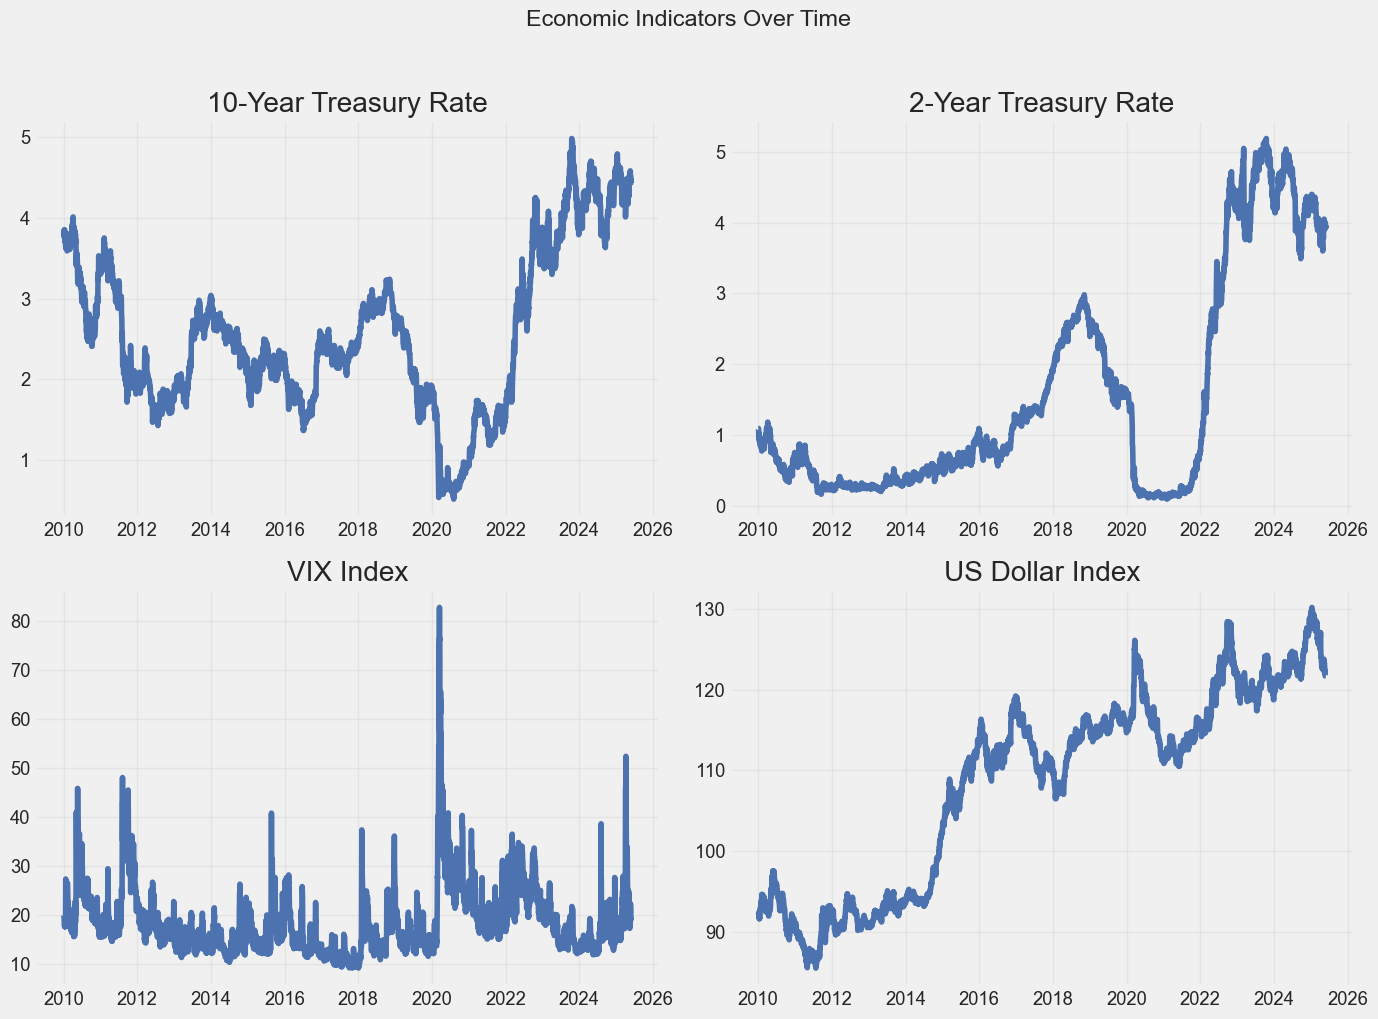

In [37]:
# Plot key economic indicators
plt.figure(figsize=(14, 10))

indicators = ['DGS10', 'DGS2', 'VIXCLS', 'DTWEXBGS']
titles = ['10-Year Treasury Rate', '2-Year Treasury Rate', 'VIX Index', 'US Dollar Index']

for i, (indicator, title) in enumerate(zip(indicators, titles)):
    plt.subplot(2, 2, i+1)
    plt.plot(economic_data_filled.index, economic_data_filled[indicator])
    plt.title(title)
    plt.tight_layout()

plt.suptitle('Economic Indicators Over Time', y=1.02)
plt.tight_layout()
plt.show()

## 6. Summary

In this notebook, we have:

1. Collected historical FX data for major currency pairs
2. Gathered relevant economic indicators
3. Cleaned and preprocessed the data
4. Created derived features including returns, volatility measures, and lagged variables
5. Merged all data into a single dataset for modeling
6. Visualized key aspects of the data

The processed data is now ready for exploratory analysis and model development in the next notebooks.